# **Models_4Q**

Naive Bayes, dense layer and CNN models for 4 moods classification.

## Mount drive and import libraries

In [1]:
# Mount a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import libraries
import pickle
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd
import random

import collections

!pip install -U bcolz
import bcolz
import os

# SK-learn libraries for learning.
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn

# NLP libraries
import nltk, re, pprint, string
# from nltk import word_tokenize
# nltk.download('punkt')

# Set seed
random.seed(8)
np.random.seed(seed=13)

Requirement already up-to-date: bcolz in /usr/local/lib/python3.6/dist-packages (1.2.1)


Using TensorFlow backend.


## Import data

In [0]:
# Path to the file MoodyLyrics4Q_raw.pkl
path_lyrics = "/content/drive/My Drive/Fall 2019/W266/Project/2_clean_data/data_lyrics_clean.pkl"

# Unpickle the dataset in pandas dataframe
df = pd.read_pickle(path_lyrics)

## EDA

In [5]:
df.head(5)

,ml_index,mer_index,artist,title,mood,mood_pn,lyrics,lyrics_len
0,1.0,NaN,George Michael,I Want Your Sex,happy,pos,"There's things that you guess, And things that...",375
1,2.0,NaN,Rob Zombie,Pussy Liquor,angry,neg,"Baby: Gimme a B, Gimme a A, Gimme a B, Gimme a...",353
2,3.0,NaN,Katatonia,12,sad,neg,"Black theatre of love, Violet thatncers cast t...",88
3,4.0,NaN,Bing Crosby,Swinging On A Star,happy,pos,"Would you like to swing on a star, Carry moonb...",285
4,5.0,NaN,Ludacris,Get Back,angry,neg,"Hands up! Hands up, Here's another one, And a ...",835


In [6]:
# Explore the dataset
df.tail(5)

,ml_index,mer_index,artist,title,mood,mood_pn,lyrics,lyrics_len
2569,NaN,MT0033391277,Simon Garfunkel,April Come She Will,relaxed,pos,", April come she will, When streams are ripe a...",67
2570,NaN,MT0033733581,Sinead O'Connor,Door Peep,relaxed,pos,"Door peep shall not enter this a holy land, Wh...",171
2571,NaN,MT0033994043,Rosemary Clooney,Tenderly,relaxed,pos,The evening breeze caressed the trees tenderly...,70
2572,NaN,MT0034992204,John Denver,Farewell Andromeda (Welcome to My Morning),relaxed,pos,"Welcome to my morning, Welcome to my thaty, I'...",172
2573,NaN,MT0035119161,Elton John,Dixie Lily,relaxed,pos,"Showboat coming up the river, See her lanterns...",129


We check that the dataset is properly balanced in number of examples per each mood

In [7]:
# Some key properties of the dataset
n_songs = df.shape[0]
n_pos = df[df['mood_pn']=='pos'].shape[0]
mood_list = df['mood'].unique()
n_mood_pn_list = df['mood_pn'].unique()
print(f"There are {n_songs} songs, {n_pos} with positive mood and {n_songs - n_pos} with negative mood.")

There are 2574 songs, 1255 with positive mood and 1319 with negative mood.


In [8]:
# Description by mood
df.groupby(by='mood').count()

,ml_index,mer_index,artist,title,mood_pn,lyrics,lyrics_len
mood,,,,,,,
angry,468,204,672,672,672,672,672
happy,456,211,667,667,667,667,667
relaxed,440,148,588,588,588,588,588
sad,443,204,647,647,647,647,647


Angry, happy and sad have a similar number of examples in the dataset. Relaxed are a bit lower than the rest, though.

## Train/Test split

We will define a train/test split ratio

In [0]:
# test ratio portion over all observations
test_ratio = 0.2

### Pos/neg mood

In [0]:
# Split the data into random train and test subsets for pos/neg mood prediction
X_pn_train, X_pn_test, y_pn_train, y_pn_test = train_test_split(df['lyrics'], df['mood_pn'], test_size=test_ratio, random_state=8)

In [11]:
# Check train and test split
print(f'Train size: {len(y_pn_train)}')
print(f'Test size: {len(y_pn_test)}')


# Check balance in random subsets
print(f'\nPositive mood in train: {np.sum(y_pn_train=="pos")}')
print(f'Negative mood in train: {np.sum(y_pn_train=="neg")}')
print(f'\nPositive mood in test: {np.sum(y_pn_test=="pos")}')
print(f'Negative mood in test: {np.sum(y_pn_test=="neg")}')

Train size: 2059
Test size: 515

Positive mood in train: 1005
Negative mood in train: 1054

Positive mood in test: 250
Negative mood in test: 265


### 4Q mood

We need numerical values for the 4 mood categories. We will use 0, 1, 2, and 3 for 'happy'(Q1), 'angry' (Q2), 'sad' (Q3) and 'relaxed' (Q4)

In [0]:
# Make mood variable to be categorical
categories = ['happy', 'angry', 'sad', 'relaxed']
df['mood'] = pd.Categorical(df['mood'], categories=['happy', 'angry', 'sad', 'relaxed'])

In [0]:
df['mood_code'] = df['mood'].cat.codes

In [14]:
df.head(11)

,ml_index,mer_index,artist,title,mood,mood_pn,lyrics,lyrics_len,mood_code
0,1.0,NaN,George Michael,I Want Your Sex,happy,pos,"There's things that you guess, And things that...",375,0
1,2.0,NaN,Rob Zombie,Pussy Liquor,angry,neg,"Baby: Gimme a B, Gimme a A, Gimme a B, Gimme a...",353,1
2,3.0,NaN,Katatonia,12,sad,neg,"Black theatre of love, Violet thatncers cast t...",88,2
3,4.0,NaN,Bing Crosby,Swinging On A Star,happy,pos,"Would you like to swing on a star, Carry moonb...",285,0
4,5.0,NaN,Ludacris,Get Back,angry,neg,"Hands up! Hands up, Here's another one, And a ...",835,1
5,6.0,NaN,Hole,Violet,angry,neg,"And the sky was made of amethyst, And all the ...",273,1
6,7.0,NaN,Manic Street Preachers,Ifwhiteamericatoldthetruthforonedayit'sworldwo...,angry,neg,"Next Thursthaty, you are invited to watch Risi...",297,1
7,8.0,NaN,Emerson Hart,If You're Gonna Leave,sad,neg,Maybe I'm a joker. Maybe I'm a fool in your ey...,249,2
8,9.0,NaN,Megadeth,Architecture of Aggression,angry,neg,"Born from the thatrk, In the black cloak of ni...",244,1
9,10.0,NaN,Blondie,Heart of Glass,happy,pos,"Once I had a love and it was a gas, Soon turne...",229,0


In [0]:
# Split the data into random train and test subsets for 4Q mood prediction
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(df['lyrics'], df['mood_code'], test_size=0.2, random_state=8)

In [16]:
# Check balance in random subsets: train
index_train = list(y_m_train.index)
df.loc[index_train, :].groupby(by='mood').count()

,ml_index,mer_index,artist,title,mood_pn,lyrics,lyrics_len,mood_code
mood,,,,,,,,
happy,372,163,535,535,535,535,535,535
angry,370,159,529,529,529,529,529,529
sad,353,172,525,525,525,525,525,525
relaxed,354,116,470,470,470,470,470,470


In [17]:
# Check balance in random subsets:test
index_test = list(y_m_test.index)
df.loc[index_test, :].groupby(by='mood').count()

,ml_index,mer_index,artist,title,mood_pn,lyrics,lyrics_len,mood_code
mood,,,,,,,,
happy,84,48,132,132,132,132,132,132
angry,98,45,143,143,143,143,143,143
sad,90,32,122,122,122,122,122,122
relaxed,86,32,118,118,118,118,118,118


### One Hot encoding

In [0]:
# Get the integer classification of moods
data = df['mood_code']

# One hot encode
mood_encoded = to_categorical(data)

In [19]:
# Print 10 first values for mood, mood_code, and mood_encoded (one hot encoding)
for i in range(11):
  print(df['mood'][i], df['mood_code'][i], mood_encoded[i])

happy 0 [1. 0. 0. 0.]
angry 1 [0. 1. 0. 0.]
sad 2 [0. 0. 1. 0.]
happy 0 [1. 0. 0. 0.]
angry 1 [0. 1. 0. 0.]
angry 1 [0. 1. 0. 0.]
angry 1 [0. 1. 0. 0.]
sad 2 [0. 0. 1. 0.]
angry 1 [0. 1. 0. 0.]
happy 0 [1. 0. 0. 0.]
relaxed 3 [0. 0. 0. 1.]


## Models 4Q

Inspired by the example in https://medium.com/@martinpella/naive-bayes-for-sentiment-analysis-49b37db18bf8 and UC Berkeley MIDS W207 Summer 2019 assignments


Inspired by the example in the "Deep Learning with Python" book, page 188: 6.1.3 "putting it all together", applied to our dataset.


The data is already splitted in train and test datasets.

### Multinomial Naive Bayes
Naive Bayes works well with small sample sizes. Given that we have 2060 records to train on, I think this certainly qualifies.

In [20]:
len(X_m_train), len(X_m_test), len(y_m_train), len(y_m_test)

(2059, 515, 2059, 515)

#### Monogram

We need a tokenizer

In [0]:
# tokenize definition
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Bag of words

In [0]:
vect = CountVectorizer(tokenizer=tokenize)
tf_train = vect.fit_transform(X_m_train)
tf_test = vect.transform(X_m_test)

Train term frequency contains 2060 lyrics and 16154 tokens. Each row represents one lyrics and each column how many times that token appears on the document.

In [23]:
tf_train

<2059x16405 sparse matrix of type '<class 'numpy.int64'>'
	with 212490 stored elements in Compressed Sparse Row format>

For example, the first lyrics only has 83 of the possible 16154 tokens.

In [24]:
tf_train[0]

<1x16405 sparse matrix of type '<class 'numpy.int64'>'
	with 82 stored elements in Compressed Sparse Row format>

Getting the vocabulary

In [25]:
vocab = vect.get_feature_names()
print(f'Size of the vocabulary: {len(vocab)}')
print('Sample:', vocab[1000:1008])

Size of the vocabulary: 16405
Sample: ['backs', 'backseat', 'backstabbed', 'backstage', 'backstreet', 'backup', 'backward', 'backwards']


In [26]:
# Define a Multinomial Naive Bayes classifier
clf_MNB = MultinomialNB()

# Define the alpha parameter grid, taken from project 1 question
alpha_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 0.9, 1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 2, 3, 5, 7, 8, 10]}

# GridSearchCV method call to extract parameter values from Bernoulli Naive Bayes estimator
clf = GridSearchCV(clf_MNB, alpha_grid, cv=5, verbose=0, n_jobs=-1)

# Fit with the train data set
clf.fit(tf_train, y_m_train)

# Show the param that got the best result
print("\nMultinomial Naive Bayes model:\n")
print("- Best parameter:", clf.best_params_)    
print("- Best accuracy:", clf.best_score_)    


Multinomial Naive Bayes model:

- Best parameter: {'alpha': 1.6}
- Best accuracy: 0.6070908207867897


We train with the best parameter and score on test dataset.

In [27]:
# Define a Multinomial Naive Bayes classifier
clf_MNB = MultinomialNB(alpha=1.6)

# Fit with the train data set
clf_MNB.fit(tf_train, y_m_train)

MNB_pred = clf_MNB.predict(tf_test)

# Score on test
score = clf_MNB.score(tf_test, y_m_test)
print(f"Multinomial Naive Bayes score: {score:0.4f}")

Multinomial Naive Bayes score: 0.5864


In [28]:
# Get the classification report. Print it
class_report = classification_report(y_m_test, MNB_pred, target_names=categories)
print("\nClassification Report:\n", class_report)

# Print confusion matrix
conf_matrix = confusion_matrix(y_m_test, MNB_pred)
print("\nConfussion matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

       happy       0.60      0.68      0.64       132
       angry       0.78      0.71      0.74       143
         sad       0.47      0.69      0.56       122
     relaxed       0.49      0.23      0.31       118

    accuracy                           0.59       515
   macro avg       0.58      0.58      0.56       515
weighted avg       0.59      0.59      0.57       515


Confussion matrix:
 [[ 90   6  21  15]
 [ 19 101  19   4]
 [ 15  14  84   9]
 [ 27   8  56  27]]


Taking a look at the most relevant words that the algorithm uses to classify positive and negative moods

In [0]:
# coef_df = pd.DataFrame({'vocab': vocab, 'coef':model.coef_.reshape(-1)})
# pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
# neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

In [0]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 8))
# fig.subplots_adjust(wspace=0.8)
# pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
# axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
# axs[0].set_title('Positive');
# neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
# axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
# axs[1].set_title('Negative');

There are some words which should not clearly belong to one of the groups, such as 'between' or 'makes', and one verb which is in both groups in different tense 'hurts'/'hurt'.

#### Bi-gram

In [0]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 3), max_df=0.95, min_df=10, sublinear_tf=True)
# vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 3), min_df=11, sublinear_tf=True)
tfidf_train = vect.fit_transform(X_m_train)
tfidf_test = vect.transform(X_m_test)

Getting the vocabulary

In [32]:
vocab = vect.get_feature_names()
print(f'Size of the vocabulary: {len(vocab)}')
print('Sample:', vocab[1000:1008])

Size of the vocabulary: 10053
Sample: [', so ,', ', so come', ', so don', ', so i', ', so if', ', so let', ', so many', ', so much']


In [33]:
# Define a Multinomial Naive Bayes classifier
clf_MNB = MultinomialNB()

# Define the alpha parameter grid, taken from project 1 question
alpha_grid = {'alpha': [0.001, 0.01, 0.09, 0.1, 0.11, 0.3, 0.4, 0.5, 0.9, 1, 1.5, 2, 3, 5, 7, 8, 10]}

# GridSearchCV method call to extract parameter values from Bernoulli Naive Bayes estimator
clf = GridSearchCV(clf_MNB, alpha_grid, cv=5, verbose=0, n_jobs=-1)

# Fit with the train data set
clf.fit(tfidf_train, y_m_train)

# Show the param that got the best result
print("\nMultinomial Naive Bayes model:\n")
print("- Best parameter:", clf.best_params_)    
print("- Best accuracy:", clf.best_score_)    


Multinomial Naive Bayes model:

- Best parameter: {'alpha': 0.5}
- Best accuracy: 0.626517727051967


We train with the best parameter and score on test dataset.

In [34]:
# Define a Multinomial Naive Bayes classifier
clf_MNB = MultinomialNB(alpha=0.5)

# Fit with the train data set
clf_MNB.fit(tfidf_train, y_m_train)

MNB_pred = clf_MNB.predict(tfidf_test)

# Score on test
score = clf_MNB.score(tfidf_test, y_m_test)
print(f"Multinomial Naive Bayes score: {score:0.4f}")

Multinomial Naive Bayes score: 0.6233


In [35]:
# Get the classification report. Print it
class_report = classification_report(y_m_test, MNB_pred, target_names=categories)
print("\nClassification Report:\n", class_report)

# Print confusion matrix
conf_matrix = confusion_matrix(y_m_test, MNB_pred)
print("\nConfussion matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

       happy       0.59      0.74      0.66       132
       angry       0.84      0.72      0.77       143
         sad       0.51      0.66      0.58       122
     relaxed       0.57      0.33      0.42       118

    accuracy                           0.62       515
   macro avg       0.63      0.61      0.61       515
weighted avg       0.64      0.62      0.62       515


Confussion matrix:
 [[ 98   6  16  12]
 [ 23 103  15   2]
 [ 13  12  81  16]
 [ 31   2  46  39]]


### Dense Layer Neural Network

Inspired by the example in the "Deep Learning with Python" book, page 188: 6.1.3 "putting it all together", applied to our dataset and changing the output to 4 categories instead of just a binomial one.


We start training a simple neural network to predict positive o negative mood of a song based on its lyrics.

We have 2574 songs in total and we will use 1850 (72%) for training, 400 (16%)for validation and the rest -324 (12%)- for testing.



So our model should be able to bet a basic model that would always predict the most frequent mood, that is ...

In [36]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
# Lists of labels (pos=1, neg=0) and lyrics
texts = df['lyrics']
labels = list(mood_encoded)

# Define n_samples as the total size of dataset
n_samples = len(labels)

In [0]:
# Set random seed for reproducibility
np.random.seed(seed=13)

In [39]:
# Tokenizing the text of the raw lyrics data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Design parameters
maxlen = 100 # Cuts off reviews after maxlen words
training_samples = 1850 # Trains on training_samples samples
validation_samples = 400 # Validates on validation_samples samples
test_samples = n_samples - training_samples - validation_samples

if test_samples<1:
  print("No test sample. Training plus validation is bigger than the total number of samples")
max_words = 7000 # Considers only the top max_words words in the dataset

# Prepare the data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Get the train and validation data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples: training_samples + validation_samples + test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + test_samples]

Found 18875 unique tokens.
Shape of data tensor: (2574, 100)
Shape of label tensor: (2574, 4)


In [40]:
# Parsing the GloVe word-embeddings file
import os

glove_dir = "/content/drive/My Drive/Fall 2019/W266/Project/glove.6B"
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
# f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 50
# embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector #Words not found in the embedding index will be all zeros

In [42]:
# Import libraries for model definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

# Model definition
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dropout(rate=0.3)) # There is no dropout layer in the example
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3)) # There is no dropout layer in the example
model.add(Dense(4, activation='softmax')) # softmax instead of 

# Show a summary of the model
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           350000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160032    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
T

In [43]:
# Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [44]:
# Training and evaluation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model_4Q.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1850 samples, validate on 400 samples
Epoch 1/10
1850/1850 [==============================] - 1s 544us/step - loss: 1.4292 - acc: 0.2670 - val_loss: 1.3674 - val_acc: 0.2800
Epoch 2/10
1850/1850 [==============================] - 0s 233us/step - loss: 1.3300 - acc: 0.3568 - val_loss: 1.3366 - val_acc: 0.3900
Epoch 3/10
1850/1850 [==============================] - 0s 233us/step - loss: 1.2522 - acc: 0.4227 - val_loss: 1.3021 - val_acc: 0.3925
Epoch 4/10
1850/1850 [==============================] - 0s 233us/step - loss: 1.1914 - acc: 0.4465 - val_loss: 1.2564 - val_acc: 0.4400
Epoch 5/10
1850/1850 [==============================] - 0s 229us/step - loss: 1.1119 - acc: 0.4849 - val_loss: 1.2399 - val_acc: 0.4325
Epoch 6/10
1850/1850 [==============================] - 0s 240us/step - loss: 1.0425 - acc: 0.5222 - val_loss: 1.2111 - val_acc: 0.4550
Epoch 7/10
1850/1850 [=================

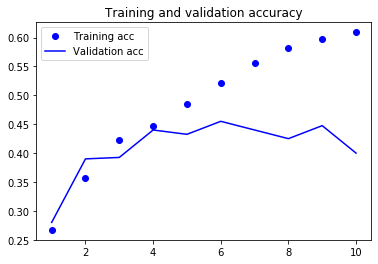

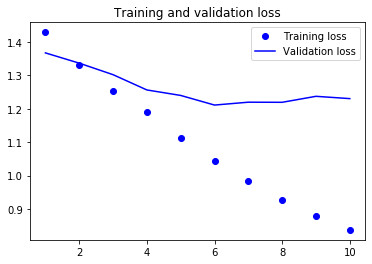

In [45]:
# Plotting the results for training and validation datasets
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [46]:
# Result for test dataset
model.load_weights('pre_trained_glove_model_4Q.h5')
print(f'\nTest {model.metrics_names[0]} is {model.evaluate(x_test, y_test)[0]}')
print(f'\nTest {model.metrics_names[1]} is {model.evaluate(x_test, y_test)[1]}')

324/324 [==============================] - 0s 63us/step

Test loss is 1.2252931940702745
324/324 [==============================] - 0s 79us/step

Test acc is 0.45987654320987653


In [0]:
# Calculate the prediction for the x_test
y_pred = model.predict(x_test)

In [0]:
# Get the index for the maximum value in each array of the prediction
y_pred_mood = np.argmax(y_pred, axis=1)
# y_pred_mood

In [49]:
y_test_mood = np.argmax(y_test, axis=1)
y_test_mood

array([2, 0, 2, 2, 3, 3, 1, 0, 1, 3, 3, 3, 0, 1, 1, 1, 2, 0, 0, 2, 1, 3,
       2, 1, 3, 0, 0, 3, 1, 1, 2, 0, 0, 3, 1, 1, 1, 3, 2, 2, 0, 0, 3, 1,
       3, 0, 1, 1, 3, 1, 3, 2, 1, 0, 1, 1, 3, 3, 1, 2, 1, 3, 2, 3, 0, 3,
       0, 2, 2, 3, 0, 2, 3, 0, 0, 3, 1, 2, 3, 1, 2, 2, 2, 1, 0, 0, 3, 3,
       2, 2, 3, 2, 0, 1, 1, 3, 1, 1, 1, 1, 0, 2, 0, 0, 3, 3, 0, 2, 0, 2,
       2, 2, 3, 2, 2, 2, 2, 0, 1, 1, 1, 3, 0, 1, 1, 0, 0, 0, 2, 3, 1, 2,
       2, 0, 3, 2, 0, 0, 1, 2, 0, 1, 2, 3, 1, 0, 1, 0, 3, 1, 1, 2, 3, 0,
       3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 0, 1, 1, 0, 2, 3, 1, 3,
       2, 3, 1, 0, 0, 1, 2, 0, 3, 1, 3, 3, 2, 1, 3, 3, 1, 0, 3, 3, 0, 1,
       3, 2, 3, 0, 0, 3, 2, 3, 1, 0, 1, 3, 2, 3, 3, 3, 1, 0, 1, 0, 2, 3,
       0, 0, 1, 2, 1, 0, 3, 1, 2, 2, 1, 0, 3, 1, 1, 2, 3, 0, 0, 2, 1, 0,
       0, 3, 1, 3, 2, 0, 0, 2, 0, 3, 3, 0, 2, 0, 1, 0, 1, 0, 1, 3, 2, 3,
       2, 3, 1, 1, 0, 3, 3, 0, 1, 2, 2, 2, 1, 1, 0, 3, 3, 1, 3, 3, 0, 2,
       2, 1, 3, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 1, 1,

In [50]:
# Get the classification report. Print it
class_report = classification_report(y_test_mood, y_pred_mood, target_names=categories)
print("\nClassification Report:\n", class_report)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test_mood, y_pred_mood)
print("\nConfussion matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

       happy       0.59      0.53      0.56        90
       angry       0.56      0.54      0.55        85
         sad       0.34      0.33      0.33        70
     relaxed       0.35      0.41      0.37        79

    accuracy                           0.46       324
   macro avg       0.46      0.45      0.45       324
weighted avg       0.47      0.46      0.46       324


Confussion matrix:
 [[48 12  8 22]
 [14 46 16  9]
 [ 8 10 23 29]
 [12 14 21 32]]


In [51]:
categories

['happy', 'angry', 'sad', 'relaxed']

### CNN

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input, concatenate
from keras.optimizers import Adam

In [53]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
# Lists of labels (pos=1, neg=0) and lyrics
texts = df['lyrics']
labels = list(mood_encoded)

# Define n_samples as the total size of dataset
n_samples = len(labels)

In [0]:
# Set random seed for reproducibility
np.random.seed(seed=13)

In [0]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

In [57]:
word_index = tokenizer.word_index
print(len(word_index))
print(word_index)

18876
{'<OOV>': 1, 'the': 2, 'i': 3, 'you': 4, 'to': 5, 'and': 6, 'a': 7, 'me': 8, 'my': 9, 'it': 10, 'in': 11, 'of': 12, 'your': 13, 'that': 14, 'on': 15, "i'm": 16, 'is': 17, 'all': 18, 'for': 19, 'so': 20, 'we': 21, 'be': 22, "don't": 23, 'with': 24, "it's": 25, 'just': 26, 'no': 27, 'but': 28, 'love': 29, 'like': 30, 'this': 31, 'know': 32, 'up': 33, 'what': 34, 'oh': 35, 'now': 36, 'when': 37, 'do': 38, 'get': 39, 'got': 40, 'can': 41, 'out': 42, 'if': 43, 'have': 44, 'down': 45, "you're": 46, 'one': 47, 'are': 48, 'going': 49, 'go': 50, 'yeah': 51, 'was': 52, 'they': 53, 'come': 54, 'see': 55, 'will': 56, 'time': 57, 'not': 58, 'baby': 59, 'never': 60, 'from': 61, 'want': 62, "can't": 63, 'she': 64, 'as': 65, 'say': 66, 'take': 67, 'at': 68, 'make': 69, 'way': 70, 'because': 71, 'right': 72, 'let': 73, 'her': 74, 'back': 75, 'how': 76, 'away': 77, "i've": 78, 'more': 79, "i'll": 80, 'he': 81, 'feel': 82, 'there': 83, 'here': 84, 'life': 85, 'world': 86, 'tell': 87, 'by': 88, 'man

In [0]:
sequences = tokenizer.texts_to_sequences(texts)

In [59]:
print(word_index)
print(texts[3])
print(sequences[3])

{'<OOV>': 1, 'the': 2, 'i': 3, 'you': 4, 'to': 5, 'and': 6, 'a': 7, 'me': 8, 'my': 9, 'it': 10, 'in': 11, 'of': 12, 'your': 13, 'that': 14, 'on': 15, "i'm": 16, 'is': 17, 'all': 18, 'for': 19, 'so': 20, 'we': 21, 'be': 22, "don't": 23, 'with': 24, "it's": 25, 'just': 26, 'no': 27, 'but': 28, 'love': 29, 'like': 30, 'this': 31, 'know': 32, 'up': 33, 'what': 34, 'oh': 35, 'now': 36, 'when': 37, 'do': 38, 'get': 39, 'got': 40, 'can': 41, 'out': 42, 'if': 43, 'have': 44, 'down': 45, "you're": 46, 'one': 47, 'are': 48, 'going': 49, 'go': 50, 'yeah': 51, 'was': 52, 'they': 53, 'come': 54, 'see': 55, 'will': 56, 'time': 57, 'not': 58, 'baby': 59, 'never': 60, 'from': 61, 'want': 62, "can't": 63, 'she': 64, 'as': 65, 'say': 66, 'take': 67, 'at': 68, 'make': 69, 'way': 70, 'because': 71, 'right': 72, 'let': 73, 'her': 74, 'back': 75, 'how': 76, 'away': 77, "i've": 78, 'more': 79, "i'll": 80, 'he': 81, 'feel': 82, 'there': 83, 'here': 84, 'life': 85, 'world': 86, 'tell': 87, 'by': 88, 'man': 89,

In [0]:
# Design parameters
maxlen = 250 # Cuts off reviews after maxlen words
training_samples = 1850 # Trains on training_samples samples
validation_samples = 400 # Validates on validation_samples samples
test_samples = n_samples - training_samples - validation_samples
if test_samples<1:
  print("No test sample. Training plus validation is bigger than the total number of samples")
# max_words = 7000 # Considers only the top max_words words in the dataset

In [61]:
# Prepare the data
data = pad_sequences(sequences, padding='pre', maxlen=maxlen) # 'pre' is the default value, but good to show in case you want to change it
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (2574, 250)
Shape of label tensor: (2574, 4)


In [0]:
# Get the train, validation data and test data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples: training_samples + validation_samples + test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + test_samples]

In [63]:
# Model definition
model = Sequential([Embedding(input_dim=len(word_index)+1, output_dim=200, input_length=maxlen),
                    SpatialDropout1D(0.2),
                    Convolution1D(64, 5, padding='same', activation='relu'),
                    MaxPooling1D(),
                    Flatten(),
                    Dense(100, activation='relu'),
                    Dropout(0.1),
                    Dense(4, activation='softmax')])

# Show a summary of the model
model.summary()

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 200)          3775400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 64)           64064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               800100    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)             

In [64]:
# Fit model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=6, batch_size=64)

# Save model
model.save_weights('cnn_model_4Q.h5')

Train on 1850 samples, validate on 400 samples
Epoch 1/6
1850/1850 [==============================] - 9s 5ms/step - loss: 1.3554 - acc: 0.3162 - val_loss: 1.2989 - val_acc: 0.3725
Epoch 2/6
1850/1850 [==============================] - 8s 4ms/step - loss: 1.2390 - acc: 0.4427 - val_loss: 1.2807 - val_acc: 0.3875
Epoch 3/6
1850/1850 [==============================] - 8s 4ms/step - loss: 0.9478 - acc: 0.6395 - val_loss: 1.0845 - val_acc: 0.5450
Epoch 4/6
1850/1850 [==============================] - 8s 4ms/step - loss: 0.4706 - acc: 0.8568 - val_loss: 1.2178 - val_acc: 0.5575
Epoch 5/6
1850/1850 [==============================] - 8s 4ms/step - loss: 0.2113 - acc: 0.9476 - val_loss: 1.2056 - val_acc: 0.6275
Epoch 6/6
1850/1850 [==============================] - 8s 4ms/step - loss: 0.0773 - acc: 0.9859 - val_loss: 1.3352 - val_acc: 0.6075


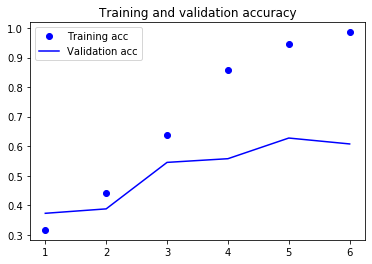

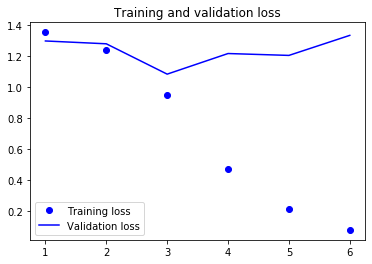

In [65]:
# Plotting the results for training and validation datasets
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [66]:
# Result for test dataset
model.load_weights('cnn_model_4Q.h5')
print(f'\nTest {model.metrics_names[0]} is {model.evaluate(x_test, y_test)[0]}')
print(f'\nTest {model.metrics_names[1]} is {model.evaluate(x_test, y_test)[1]}')

324/324 [==============================] - 0s 819us/step

Test loss is 1.4132641156514485
324/324 [==============================] - 0s 892us/step

Test acc is 0.5802469135802469


In [0]:
# Calculate the prediction for the x_test
y_pred = model.predict(x_test)

In [68]:
# Get the index for the maximum value in each array of the prediction
y_pred_mood = np.argmax(y_pred, axis=1)
y_pred_mood

array([0, 0, 0, 3, 3, 0, 2, 0, 1, 2, 3, 1, 2, 3, 1, 1, 3, 0, 0, 2, 1, 2,
       2, 1, 0, 0, 0, 0, 1, 1, 3, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 3, 2,
       0, 0, 0, 1, 2, 0, 3, 1, 1, 0, 1, 1, 3, 0, 3, 2, 2, 2, 2, 2, 1, 3,
       0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 1, 3,
       1, 0, 2, 3, 1, 1, 1, 3, 1, 0, 1, 1, 0, 3, 0, 0, 3, 3, 0, 2, 0, 2,
       1, 3, 2, 2, 0, 1, 1, 2, 2, 1, 1, 3, 0, 1, 1, 0, 0, 2, 1, 0, 1, 3,
       3, 0, 1, 1, 0, 3, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 0, 1, 1, 3, 3, 0,
       1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 0, 1, 3, 1, 1, 1, 3, 1, 2, 1, 3,
       2, 0, 0, 0, 3, 0, 2, 0, 2, 2, 0, 3, 2, 1, 3, 2, 1, 0, 3, 3, 1, 1,
       2, 2, 3, 2, 3, 3, 2, 3, 3, 1, 1, 3, 0, 3, 0, 3, 2, 0, 1, 2, 2, 2,
       0, 1, 0, 2, 2, 0, 1, 1, 1, 2, 1, 0, 3, 1, 1, 2, 3, 0, 1, 0, 1, 0,
       0, 2, 1, 2, 3, 2, 0, 0, 0, 3, 3, 0, 2, 3, 1, 2, 1, 3, 1, 3, 1, 2,
       2, 2, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 3, 1, 0, 3, 1, 2,
       3, 1, 0, 1, 0, 1, 3, 0, 0, 1, 2, 0, 2, 1, 1,

In [69]:
y_test_mood = np.argmax(y_test, axis=1)
y_test_mood

array([2, 0, 2, 2, 3, 3, 1, 0, 1, 3, 3, 3, 0, 1, 1, 1, 2, 0, 0, 2, 1, 3,
       2, 1, 3, 0, 0, 3, 1, 1, 2, 0, 0, 3, 1, 1, 1, 3, 2, 2, 0, 0, 3, 1,
       3, 0, 1, 1, 3, 1, 3, 2, 1, 0, 1, 1, 3, 3, 1, 2, 1, 3, 2, 3, 0, 3,
       0, 2, 2, 3, 0, 2, 3, 0, 0, 3, 1, 2, 3, 1, 2, 2, 2, 1, 0, 0, 3, 3,
       2, 2, 3, 2, 0, 1, 1, 3, 1, 1, 1, 1, 0, 2, 0, 0, 3, 3, 0, 2, 0, 2,
       2, 2, 3, 2, 2, 2, 2, 0, 1, 1, 1, 3, 0, 1, 1, 0, 0, 0, 2, 3, 1, 2,
       2, 0, 3, 2, 0, 0, 1, 2, 0, 1, 2, 3, 1, 0, 1, 0, 3, 1, 1, 2, 3, 0,
       3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 0, 1, 1, 0, 2, 3, 1, 3,
       2, 3, 1, 0, 0, 1, 2, 0, 3, 1, 3, 3, 2, 1, 3, 3, 1, 0, 3, 3, 0, 1,
       3, 2, 3, 0, 0, 3, 2, 3, 1, 0, 1, 3, 2, 3, 3, 3, 1, 0, 1, 0, 2, 3,
       0, 0, 1, 2, 1, 0, 3, 1, 2, 2, 1, 0, 3, 1, 1, 2, 3, 0, 0, 2, 1, 0,
       0, 3, 1, 3, 2, 0, 0, 2, 0, 3, 3, 0, 2, 0, 1, 0, 1, 0, 1, 3, 2, 3,
       2, 3, 1, 1, 0, 3, 3, 0, 1, 2, 2, 2, 1, 1, 0, 3, 3, 1, 3, 3, 0, 2,
       2, 1, 3, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 1, 1,

In [72]:
# Get the classification report. Print it
class_report = classification_report(y_test_mood, y_pred_mood, target_names=categories)
print("\nClassification Report:\n", class_report)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test_mood, y_pred_mood)
print("\nConfussion matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

       happy       0.60      0.62      0.61        90
       angry       0.63      0.79      0.70        85
         sad       0.46      0.46      0.46        70
     relaxed       0.60      0.42      0.49        79

    accuracy                           0.58       324
   macro avg       0.57      0.57      0.57       324
weighted avg       0.58      0.58      0.57       324


Confussion matrix:
 [[56 17  9  8]
 [ 8 67  7  3]
 [11 16 32 11]
 [19  6 21 33]]
